In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler
import pickle
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from keras import regularizers, layers, optimizers, initializers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(f'Current GPU allocator: {os.getenv("TF_GPU_ALLOCATOR")}')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print(f'Setting memory growth for {gpu}')
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
    

2024-04-21 14:37:37.646770: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 14:37:38.642019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Current GPU allocator: cuda_malloc_async
Setting memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-04-21 14:37:39.571239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 14:37:39.842289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 14:37:39.842364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
study_name = '419_stdminmax_lrred_images_3'

In [3]:

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [4]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [5]:
sd_columns = [col for col in train_df.columns if col.endswith('_sd')]
train_df.drop(columns=sd_columns, inplace=True)

In [6]:
train_images_path = './data/train_images/'
test_images_path = './data/test_images/'    

train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(train_images_path, f'{x}.jpeg'))
test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(test_images_path, f'{x}.jpeg'))

In [7]:
for column in mean_columns:
    lower_quantile = train_df[column].quantile(0.005)
    upper_quantile = train_df[column].quantile(0.985)  
    train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]

In [8]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, trait in enumerate(mean_columns):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, 5 + 1))
    train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# Concatenate the bins into a final bin
train_df["final_bin"] = (
    train_df[[f"bin_{i}" for i in range(len(mean_columns))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
train_df = train_df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
    train_df.loc[valid_idx, "fold"] = fold

/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [9]:
train_original = train_df.copy()
train_plot = train_df.copy()
sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Num Train: 39335 | Num Valid: 9833


In [10]:
import glob



directory_path = './NN_search'
pattern = f"{directory_path}/{study_name}*.h5"

files = glob.glob(pattern)

max_r2_score = float('-inf')
best_model = None

# Käy läpi jokainen tiedosto ja etsi suurin r2_score_inv
for file in files:
    value = float(file.split('best_val')[1].split('_')[1])
    if value > max_r2_score:
        max_r2_score = value
        best_model = file


# Tulosta suurin löydetty r2_score_inv ja vastaava tiedosto
print(f"Best R2-score: {max_r2_score:.5f}")
if best_model:
    print(f"Best model: {best_model}")
else:
    print("No best model found")

best_log_transforms_name =  f'./NN_search/{study_name}_{max_r2_score:.5f}_best_log_transforms.pickle'
best_scalers_name = f'./NN_search/{study_name}_{max_r2_score:.5f}_best_scalers.pickle'

print(f'Opening log transforms from {best_log_transforms_name}')
with open(best_log_transforms_name, 'rb') as f:
    log_transforms = pickle.load(f)

print(f'Opening scalers from {best_scalers_name}')
with open(best_scalers_name, 'rb') as f:
    scaler_transforms = pickle.load(f)


def r2_score_tf(y_true, y_pred):

    try: 
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
        r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
        r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2) 
        return tf.reduce_mean(tf.maximum(r2, 0.0))
    except Exception as e:
        # print(f'Error in r2_score_tf: {e}')
        return float('-inf')
    
custom_objects = {"r2_score_tf": r2_score_tf}




        

Best R2-score: 0.24839
Best model: ./NN_search/419_stdminmax_lrred_images_3_best_val_0.24839_model.h5
Opening log transforms from ./NN_search/419_stdminmax_lrred_images_3_0.24839_best_log_transforms.pickle
Opening scalers from ./NN_search/419_stdminmax_lrred_images_3_0.24839_best_scalers.pickle


In [11]:
print(f'Scaler are: {scaler_transforms}')
print(f'Log transforms are: {log_transforms}')

Scaler are: {'X4_mean': None, 'X11_mean': None, 'X18_mean': None, 'X50_mean': None, 'X26_mean': None, 'X3112_mean': None}
Log transforms are: {'X4_mean': 30, 'X11_mean': 20, 'X18_mean': 30, 'X50_mean': None, 'X26_mean': 30, 'X3112_mean': 5}


In [12]:
import tensorflow_addons as tfa

def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_hue(img, max_delta=0.1)
    img = tf.image.random_saturation(img, lower=0.9, upper=1.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    img = tf.image.random_jpeg_quality(img, min_jpeg_quality=85, max_jpeg_quality=100)

    angle = tf.random.uniform([], minval=-np.pi/8, maxval=np.pi/8, dtype=tf.float32)
    img = tfa.image.rotate(img, angles=angle)

    crop_size = tf.random.uniform(shape=[], minval=420, maxval=480, dtype=tf.int32)
    img = tf.image.random_crop(img, size=[crop_size, crop_size, 3])
    img = tf.image.resize(img, [480, 480]) 

    img = tfa.image.random_cutout(img, mask_size=(50, 50), constant_values=0)

    return img


def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    img = augment_image(img)  
    # img = tf.cast(img, tf.uint8)    
    return img

def process_image_valid(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    # img = tf.cast(img, tf.uint8)
    return img



# Define your dataset processing function
def process_path_train(file_path, targets):
    img = process_image(file_path)
    return img, targets


def process_path_valid(file_path, targets):
    img = process_image_valid(file_path)
    return img, targets


In [13]:
y_train = train_df[mean_columns]
y_valid = valid_df[mean_columns]


y_train_transformed = y_train.copy()
y_valid_transformed = y_valid.copy()


for target, log_base in log_transforms.items():
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        y_train_transformed[target] = np.log(y_train[target]) / np.log(log_base)
        y_valid_transformed[target] = np.log(y_valid[target]) / np.log(log_base)

    elif log_base == 'sqrt':
        y_train_transformed[target] = np.sqrt(y_train[target])
        y_valid_transformed[target] = np.sqrt(y_valid[target])

    elif log_base == 'cbrt':
        y_train_transformed[target] = np.cbrt(y_train[target])
        y_valid_transformed[target] = np.cbrt(y_valid[target])

    else:
        y_train_transformed[target] = y_train[target]
        y_valid_transformed[target] = y_valid[target]    

for target, scaler in scaler_transforms.items():
    if scaler is not None:
        y_train_transformed[target] = scaler.transform(y_train_transformed[target].values.reshape(-1, 1)).flatten()
        y_valid_transformed[target] = scaler.transform(y_valid_transformed[target].values.reshape(-1, 1)).flatten()


In [14]:
BUFFER_SIZE = 50000 
EPOCHS = 5
BATCH_SIZE = 11

train_images_path = train_df['image_path'].values
valid_images_path = valid_df['image_path'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, y_train_transformed.values))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images_path, y_valid_transformed.values))

train_dataset = train_dataset.map(process_path_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

len_train = len(train_dataset) * EPOCHS

print(f'LR schedule steps: {len_train}')




LR schedule steps: 17880


2024-04-21 14:37:41.959998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 14:37:41.960107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 14:37:41.960156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 14:37:42.229831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 14:37:42.229925: I tensorflow/compile

In [15]:
#####  KAKSIHAARAINEN AVG MAX IMAGELLA #####



import tensorflow as tf
import numpy as np

def r2_score_tf(y_true, y_pred):

    try: 
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
        r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
        r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2) 
        return tf.reduce_mean(tf.maximum(r2, 0.0))
    except Exception as e:
        # print(f'Error in r2_score_tf: {e}')
        return float('-inf')


# Asetetaan syötteet
image_input_avg = Input(shape=(480, 480, 3), name='image_input_avg')


# Luo perus EfficientNetV2M mallit
eff_avg_base = EfficientNetV2M(weights='imagenet', include_top=False, pooling='avg', input_tensor=image_input_avg)
eff_avg_base.trainable = True

output = Dense(6, activation='linear')(eff_avg_base.output)

finetune_model = Model(inputs=image_input_avg, outputs=output, name='finetune_model')


lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,    
    alpha=0.05,
    name="CosineDecay",
    decay_steps=len_train
)

# Aseta oppimisnopeuden aikataulu
finetune_model.compile(optimizer=optimizers.RMSprop(learning_rate=lr_schedule), loss='mae', metrics=['mse', 'mae', 'mape', r2_score_tf])






INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


2024-04-21 14:37:42.478322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


In [16]:
trainable_count = sum([tf.size(v).numpy() for v in finetune_model.trainable_weights])
non_trainable_count = sum([tf.size(v).numpy() for v in finetune_model.non_trainable_weights])
print(f"Total parameters: {trainable_count + non_trainable_count:,}")
print(f"Trainable parameters: {trainable_count:,}")
print(f"Non-trainable parameters: {non_trainable_count:,}")


Total parameters: 53,158,074
Trainable parameters: 52,866,042
Non-trainable parameters: 292,032


In [17]:
class BatchImageLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, num_batches=1, num_images_per_batch=10):
        super().__init__()
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(log_dir)
        self.num_batches = num_batches
        self.num_images_per_batch = num_images_per_batch

    def on_epoch_end(self, epoch, logs=None):
        with self.writer.as_default():
            # Käytä iter-objektia batchien iteroimiseen
            for batch, (images, _) in enumerate(self.model.train_dataset.take(self.num_batches)):
                # Otetaan vain määritelty määrä kuvia jokaisesta batchista
                images_to_log = images[:self.num_images_per_batch]
                images_to_log = tf.clip_by_value(images_to_log, 0, 255)
                images_to_log = tf.cast(images_to_log, tf.uint8)
                tf.summary.image("Augmented Images Batch {}".format(batch), images_to_log, step=epoch, max_outputs=self.num_images_per_batch)
        self.writer.flush()


In [18]:
print(f'Creating logs for trial: {study_name} in ./logs/trial_{study_name}')
log_folder = f"./logs/trial_{study_name}"
os.makedirs(log_folder, exist_ok=True)

# Aseta logitiedostojen hakemisto
tensorboard_callback = TensorBoard(log_dir=log_folder, histogram_freq=1, update_freq='batch')

Creating logs for trial: 419_stdminmax_lrred_images_3 in ./logs/trial_419_stdminmax_lrred_images_3


In [19]:

tf.keras.backend.clear_session()
gc.collect()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f'./NN_search/testifinetus_{study_name}.h5', monitor='val_mae', save_best_only=True, save_weights_only=True, mode = 'min',  verbose = 1),
    tensorboard_callback  
]

history = finetune_model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, verbose=1, callbacks=callbacks)




Epoch 1/5


2024-04-21 14:37:48.613705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_1}}]]
2024-04-21 14:37:48.614051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [39335]
	 [[{{node Placeholder/_0}}]]
2024-04-21 14:38:33.081718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


3576/3576 [==============================] - ETA: 0s - loss: 0.3303 - mse: 0.2511 - mae: 0.3304 - mape: 119.8035 - r2_score_tf: 0.1670

2024-04-21 15:14:09.668106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [9833,6]
	 [[{{node Placeholder/_1}}]]
2024-04-21 15:14:09.669044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [9833,6]
	 [[{{node Placeholder/_1}}]]



Epoch 1: val_mae improved from inf to 0.30839, saving model to ./NN_search/testifinetus_419_stdminmax_lrred_images_3.h5
3576/3576 [==============================] - 2263s 618ms/step - loss: 0.3303 - mse: 0.2511 - mae: 0.3304 - mape: 119.8035 - r2_score_tf: 0.1670 - val_loss: 0.3084 - val_mse: 0.2206 - val_mae: 0.3084 - val_mape: 155.3438 - val_r2_score_tf: 0.2234
Epoch 2/5
3576/3576 [==============================] - ETA: 0s - loss: 0.3052 - mse: 0.2159 - mae: 0.3052 - mape: 118.1725 - r2_score_tf: 0.2325
Epoch 2: val_mae improved from 0.30839 to 0.29594, saving model to ./NN_search/testifinetus_419_stdminmax_lrred_images_3.h5
3576/3576 [==============================] - 2404s 672ms/step - loss: 0.3052 - mse: 0.2159 - mae: 0.3052 - mape: 118.1725 - r2_score_tf: 0.2325 - val_loss: 0.2959 - val_mse: 0.2032 - val_mae: 0.2959 - val_mape: 120.9530 - val_r2_score_tf: 0.2606
Epoch 3/5
3576/3576 [==============================] - ETA: 0s - loss: 0.2906 - mse: 0.1989 - mae: 0.2906 - mape: 109.

In [20]:
finetune_model.load_weights(f'./NN_search/testifinetus_{study_name}.h5')
# finetune_model.save(f'./NN_search/koe', save_format='tf') # TODO tässä ongelmaa vielä, mutta ei väliä. Malli on jo olemassa ja sitä voi käyttää. 


In [21]:
for target, log_base in log_transforms.items():
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        train_plot[target] = np.log(train_plot[target]) / np.log(log_base)
        
    elif log_base == 'sqrt':
        train_plot[target] = np.sqrt(train_plot[target])
        
    elif log_base == 'cbrt':
        train_plot[target] = np.cbrt(train_plot[target])
        
    else:
        train_plot[target] = train_plot[target]
        
for target, scaler in scaler_transforms.items():
    if scaler is not None:
        train_plot[target] = scaler.transform(train_plot[target].values.reshape(-1, 1)).flatten()
        train_plot[target] = scaler.transform(train_plot[target].values.reshape(-1, 1)).flatten()

In [22]:
print(log_transforms)
print(scaler_transforms)

{'X4_mean': 30, 'X11_mean': 20, 'X18_mean': 30, 'X50_mean': None, 'X26_mean': 30, 'X3112_mean': 5}
{'X4_mean': None, 'X11_mean': None, 'X18_mean': None, 'X50_mean': None, 'X26_mean': None, 'X3112_mean': None}


In [23]:
train_original[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,0.516058,15.752458,2.772597,1.592122,24.176388,1598.763010
std,0.138489,6.961194,4.549765,0.588147,72.898061,2271.015359
min,0.181879,2.836897,0.033326,0.510491,0.005874,10.527904
25%,0.408995,11.060960,0.306775,1.185120,0.544728,263.122005
50%,0.502897,15.296873,0.676143,1.471036,2.289064,694.205681
75%,0.616053,19.505972,2.962085,1.886668,12.249738,1964.239682
max,0.883987,43.206557,24.975647,3.677128,785.944393,15639.231100


In [24]:
train_plot[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,-0.205475,0.884353,-0.022801,1.592122,0.269709,4.049182
std,0.081563,0.163549,0.436257,0.588147,0.669209,0.889701
min,-0.501121,0.348065,-1.000062,0.510491,-1.510421,1.462641
25%,-0.262864,0.802282,-0.347419,1.185120,-0.178604,3.462462
50%,-0.202097,0.910511,-0.115063,1.471036,0.243486,4.065251
75%,-0.142427,0.991651,0.319268,1.886668,0.736654,4.711496
max,-0.036256,1.257119,0.946108,3.677128,1.960159,6.000566


In [25]:
def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


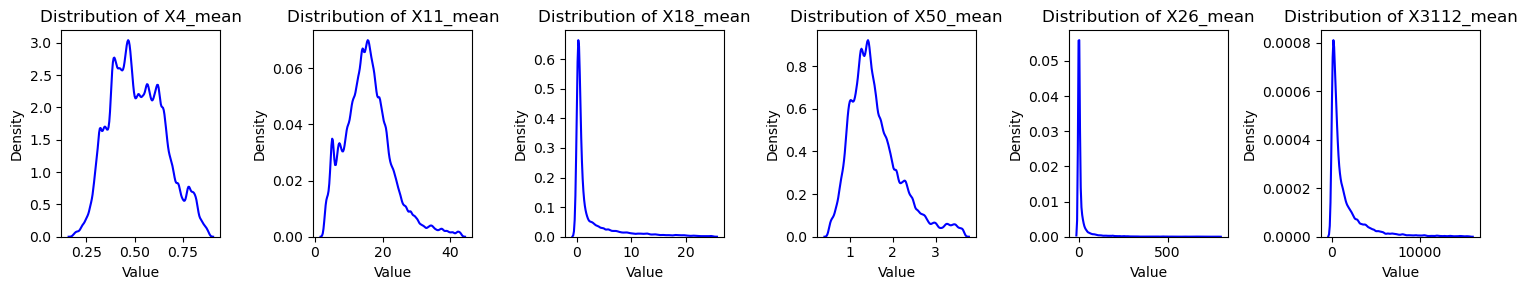

In [26]:
plot_data(train_original, mean_columns)

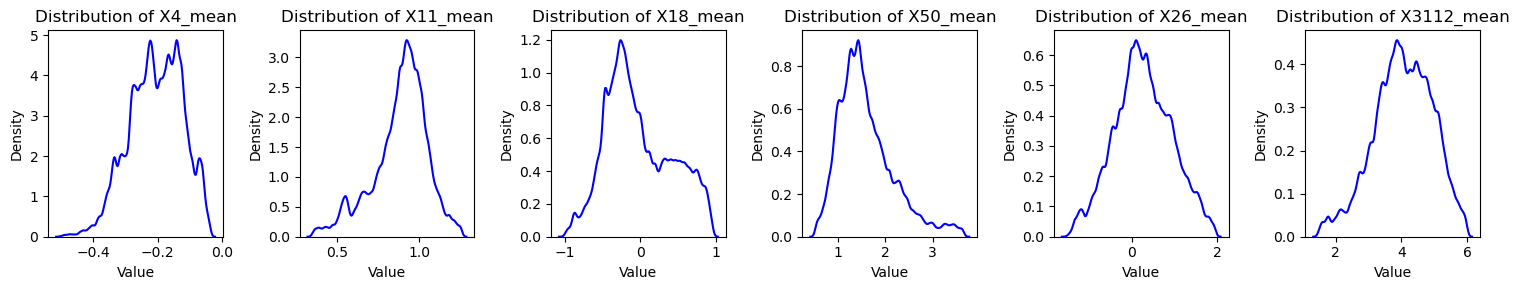

In [27]:
plot_data(train_plot, mean_columns)

In [28]:
results_training_name = './data/results_finetune_images.pickle'

if os.path.exists(results_training_name):
    results_training = pd.read_pickle(results_training_name)
else:
    columns = ['Train R2', 'Train MSE', 'Train MAE', 'Train MAPE', 'Valid R2', 'Valid MSE', 'Valid MAE', 'Valid MAPE', 'Train preds Desc', 'Valid preds Desc', 'Test preds Desc' , 'Original data Desc' 'Kaggle R2', 'Scalers', 'Log/Pot transforms']
    results_training = pd.DataFrame(columns = columns)
    results_training.index.name = 'Study name'

study_name_result = f'{study_name}_finetuned'

if study_name_result not in results_training.index:    
    results_training.loc[study_name] = [None]*len(results_training.columns)

In [31]:


train_images_path = train_df['image_path'].values
valid_images_path = valid_df['image_path'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, y_train_transformed.values))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images_path, y_valid_transformed.values))

train_dataset = train_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(process_path_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)





In [32]:

## TRAINING DATA TEST
tf.keras.backend.clear_session()
gc.collect()

train_pred = finetune_model.predict(train_dataset, verbose=1)

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        train_pred[:, i] = scaler.inverse_transform(train_pred[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    print(f'Logpot transforming target : {target}, log transform : {log_transforms[target]}')
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        train_pred[:, i] = np.power(log_base, train_pred[:, i])
    elif log_base == 'sqrt':
        train_pred[:, i] = np.square(train_pred[:, i])
    elif log_base == 'cbrt':
        train_pred[:, i] = np.power(train_pred[:, i], 3)

R2_train = r2_score(y_train, train_pred)
MSE_train = mean_squared_error(y_train, train_pred)
MAE_train = mean_absolute_error(y_train, train_pred)
MAPE_train = mean_absolute_percentage_error(y_train, train_pred)

print(f'Train scores:\nR2 : {R2_train:.5f}, MSE : {MSE_train:.5f}, MAE : {MAE_train:.5f}, MAPE : {MAPE_train:.5f}')
results_training.at[study_name_result, 'Train R2'] = R2_train
results_training.at[study_name_result, 'Train MSE'] = MSE_train
results_training.at[study_name_result, 'Train MAE'] = MAE_train
results_training.at[study_name_result, 'Train MAPE'] = MAPE_train

trainining_preds_desc = pd.DataFrame(train_pred, columns = mean_columns).describe().to_json()
results_training.at[study_name_result, 'Train preds Desc'] = trainining_preds_desc

2024-04-21 18:00:50.143552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_1}}]]
2024-04-21 18:00:50.143811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39335,6]
	 [[{{node Placeholder/_1}}]]


1230/1230 [==============================] - 345s 234ms/step
Scaler transforming target : X4_mean with scaler : None
Scaler transforming target : X11_mean with scaler : None
Scaler transforming target : X18_mean with scaler : None
Scaler transforming target : X50_mean with scaler : None
Scaler transforming target : X26_mean with scaler : None
Scaler transforming target : X3112_mean with scaler : None
Logpot transforming target : X4_mean, log transform : 30
Logpot transforming target : X11_mean, log transform : 20
Logpot transforming target : X18_mean, log transform : 30
Logpot transforming target : X50_mean, log transform : None
Logpot transforming target : X26_mean, log transform : 30
Logpot transforming target : X3112_mean, log transform : 5
Train scores:
R2 : 0.18435, MSE : 553286.52350, MAE : 155.51725, MAPE : 1.37980


In [33]:

## VALIDATION DATA TEST

tf.keras.backend.clear_session()
gc.collect()

valid_pred = finetune_model.predict(valid_dataset, verbose=1)

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        valid_pred[:, i] = scaler.inverse_transform(valid_pred[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        valid_pred[:, i] = np.power(log_base, valid_pred[:, i])
    elif log_base == 'sqrt':
        valid_pred[:, i] = np.square(valid_pred[:, i])
    elif log_base == 'cbrt':
        valid_pred[:, i] = np.power(valid_pred[:, i], 3)

R2_valid = r2_score(y_valid, valid_pred)
MSE_valid = mean_squared_error(y_valid, valid_pred)
MAE_valid = mean_absolute_error(y_valid, valid_pred)
MAPE_valid = mean_absolute_percentage_error(y_valid, valid_pred)

print(f'Valid scores:\nR2 : {R2_valid:.5f}, MSE : {MSE_valid:.5f}, MAE : {MAE_valid:.5f}, MAPE : {MAPE_valid:.5f}')
results_training.at[study_name_result, 'Valid R2'] = R2_valid
results_training.at[study_name_result, 'Valid MSE'] = MSE_valid
results_training.at[study_name_result, 'Valid MAE'] = MAE_valid
results_training.at[study_name_result, 'Valid MAPE'] = MAPE_valid

valid_preds_desc = pd.DataFrame(valid_pred, columns = mean_columns).describe().to_json()
results_training.at[study_name_result, 'Valid preds Desc'] = valid_preds_desc



2024-04-21 18:07:02.328282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [9833,6]
	 [[{{node Placeholder/_1}}]]
2024-04-21 18:07:02.328520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [9833,6]
	 [[{{node Placeholder/_1}}]]


308/308 [==============================] - 97s 311ms/step
Scaler transforming target : X4_mean with scaler : None
Scaler transforming target : X11_mean with scaler : None
Scaler transforming target : X18_mean with scaler : None
Scaler transforming target : X50_mean with scaler : None
Scaler transforming target : X26_mean with scaler : None
Scaler transforming target : X3112_mean with scaler : None
Valid scores:
R2 : 0.16082, MSE : 631907.08983, MAE : 173.52419, MAPE : 1.83183


In [ ]:
# TEST DATA 

BATCH_SIZE = 64

test_df_copy = test_df.copy()
submission_df = test_df_copy[['id']].copy()



test_images_path = test_df_copy['image_path'].values
test_dataset = tf.data.Dataset.from_tensor_slices(test_images_path)
test_dataset = test_dataset.map(process_path_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

tf.keras.backend.clear_session()
gc.collect()

predictions = finetune_model.predict(test_dataset, verbose=1)

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        predictions[:, i] = scaler.inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    print(f'Logpot transforming target: : {target}, log transform : {log_transforms[target]}')
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        predictions[:, i] = np.power(log_base, predictions[:, i])
    elif log_base == 'sqrt':
        predictions[:, i] = np.square(predictions[:, i])
    elif log_base == 'cbrt':
        predictions[:, i] = np.power(predictions[:, i], 3)


In [ ]:

target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

submission_df[target_columns] = predictions


In [ ]:

test_preds_desc = submission_df[target_columns].describe().to_json()
results_training.at[study_name_result, 'Test preds Desc'] = test_preds_desc 

original_data_desc = train_original[mean_columns].describe().to_json()
results_training.at[study_name_result, 'Original data Desc'] = original_data_desc



In [ ]:
print(f'{str(log_transforms.items())}')
print(f'{str(scaler_transforms.items())}')

results_training.at[study_name_result, 'Scalers'] = f'{scaler_transforms}'
results_training.at[study_name_result, 'Log/Pot transforms'] = f'{str(log_transforms.items())}'



In [ ]:
results_training.at[study_name_result, 'Kaggle R2'] = None

for index, row in results_training.iterrows():
    print(f"Study Name: {index}")
    print(f'Kaggle R2: {row["Kaggle R2"]}')
    print(f"Train R2: {row['Train R2']}, Train MSE: {row['Train MSE']}, Train MAE : {row['Train MAE']}, Train MAPE: {row['Train MAPE']}")
    print(f'Valid R2: {row["Valid R2"]}, Valid MSE: {row["Valid MSE"]}, Valid MAE: {row["Valid MAE"]}, Valid MAPE: {row["Valid MAPE"]}')
    print("-" * 50)
    print("Train preds Description:")
    display(pd.read_json(row['Train preds Desc']))
    print("Valid preds Description:")
    display(pd.read_json(row['Valid preds Desc']))
    print("Test preds Description:")
    display(pd.read_json(row['Test preds Desc']))
    print("Original data Description:")
    display(pd.read_json(row['Original data Desc']))
    

In [ ]:
submission_df.head()

In [ ]:
print(submission_df.info())

submission_df.to_csv('./data/submission.csv', index=False)

In [ ]:
with open(results_training_name, 'wb') as f:
    results_training.to_pickle(f)